## Carga de archivo

In [ ]:
import pandas as pd

df = pd.read_excel('Cupido FJ25 (Respuestas).xlsx').drop(columns=['Marca temporal','Situación sentimental'])
#df = df.replace({'SI': 1, 'NO': 0})
df.head()

,Atención,Higiene,Amabilidad,Atractiva(o),Buen humor,Afinidad de mentalidad,Desenlace
0,5,5,5,5,3,4,Éxito
1,4,5,4,3,2,2,Fallo
2,5,5,5,5,5,5,Éxito
3,5,5,5,1,5,5,Éxito
4,2,3,3,2,4,1,Fallo


In [ ]:
# Veamos si el dataset está balanceado
df['Desenlace'].value_counts()

,count
Desenlace,
Fallo,24
Éxito,19


In [ ]:
# Cuántos casos se dan?
df.groupby(['Afinidad de mentalidad','Desenlace'])['Desenlace'].count()

Afinidad de mentalidad  Desenlace
1                       Fallo         7
2                       Fallo         7
3                       Fallo         8
                        Éxito         3
4                       Éxito         6
5                       Fallo         2
                        Éxito        10
Name: Desenlace, dtype: int64

In [ ]:
# Cuántos casos se dan según afinidad?
pd.crosstab(df['Afinidad de mentalidad'], df['Desenlace'], margins=True)

Desenlace,Fallo,Éxito,All
Afinidad de mentalidad,,,
1,7,0,7
2,7,0,7
3,8,3,11
4,0,6,6
5,2,10,12
All,24,19,43


In [ ]:
# we can query for different interactions between variables, but cumbersome though
df[(df['Afinidad de mentalidad'] >= 3) & (df['Buen humor'] >= 3)].groupby('Desenlace')['Buen humor'].count()

,Buen humor
Desenlace,
Fallo,9
Éxito,19


In [ ]:
def gini(x_n):
  d = sum(x_n)
  return round(1 - sum((x/d)**2 for x in x_n), 3)

print(gini([29, 24]))
print(gini([21, 2]))
print(gini([0, 49, 5]))
print(gini([0, 50, 50]))
print(gini([50, 50, 50]))
print(gini([50, 0, 0]))

0.496
0.159
0.168
0.5
0.667
0.0


In [ ]:
grp = df[(df['Afinidad de mentalidad'] == 0) & (df['Buen humor'] == 1)].groupby('Desenlace')['Buen humor'].count()
print(gini(grp.values))
grp

0.219


Desenlace
Fallo    14
Éxito     2
Name: Buen humor, dtype: int64

In [ ]:
grp = df[(df['Afinidad de mentalidad'] == 0) & (df['Buen humor'] == 1) & (df['Situación sentimental'] == 0)].groupby('Desenlace')['Situación sentimental'].count()
print(gini(grp.values))
grp

0.278


Desenlace
Fallo    10
Éxito     2
Name: Situación sentimental, dtype: int64

In [ ]:
grp = df[(df['Afinidad de mentalidad'] == 0) & (df['Buen humor'] == 1) & (df['Situación sentimental'] == 1)].groupby('Desenlace')['Situación sentimental'].count()
print(gini(grp.values))
grp

0.0


Desenlace
Fallo    4
Name: Situación sentimental, dtype: int64

## Modelo de árbol sin restricción - todos los datos
El algoritmo CART (*Classification and Regression Trees*) es una técnica utilizada para construir **árboles de decisión**, que pueden ser utilizados tanto para problemas de **clasificación** como de **regresión**.

El objetivo del algoritmo *CART* es dividir el conjunto de datos en nodos que maximicen la homogeneidad de las clases (en clasificación) o minimicen el error cuadrático (en regresión). Para ello, se utilizan criterios de división:

* Para Clasificación: Se utiliza la impureza de Gini o la entropía. La impureza de Gini mide la probabilidad de que un elemento sea mal clasificado si se selecciona al azar.

* Para Regresión: Se utiliza la suma de los errores cuadráticos, que mide la variación de los valores en los nodos.

Veamos el árbol generado de utilizar todos los datos para sacar algunas conclusiones.

In [ ]:
# Árbol con todos los datos para analizar y aprender
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Separate features (X) and target (y)
X = df.drop('Desenlace', axis=1)
y = df['Desenlace']

# Create a Decision Tree classifier
clf = DecisionTreeClassifier()

# Train the classifier
clf.fit(X, y)

# Make predictions on the test set
y_pred = clf.predict(X)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9534883720930233


### Proceso de Creación del Árbol
1. Selección de la Mejor División: Para cada nodo, se evalúan todas las posibles divisiones y se selecciona la que minimiza la impureza o el error.
2. Crecimiento del Árbol: Se repite el proceso de división recursivamente para cada nodo hasta que se cumpla un criterio de parada, como:
* Un número mínimo de muestras en un nodo.
* Una profundidad máxima del árbol.
* No hay mejoras significativas en la impureza.

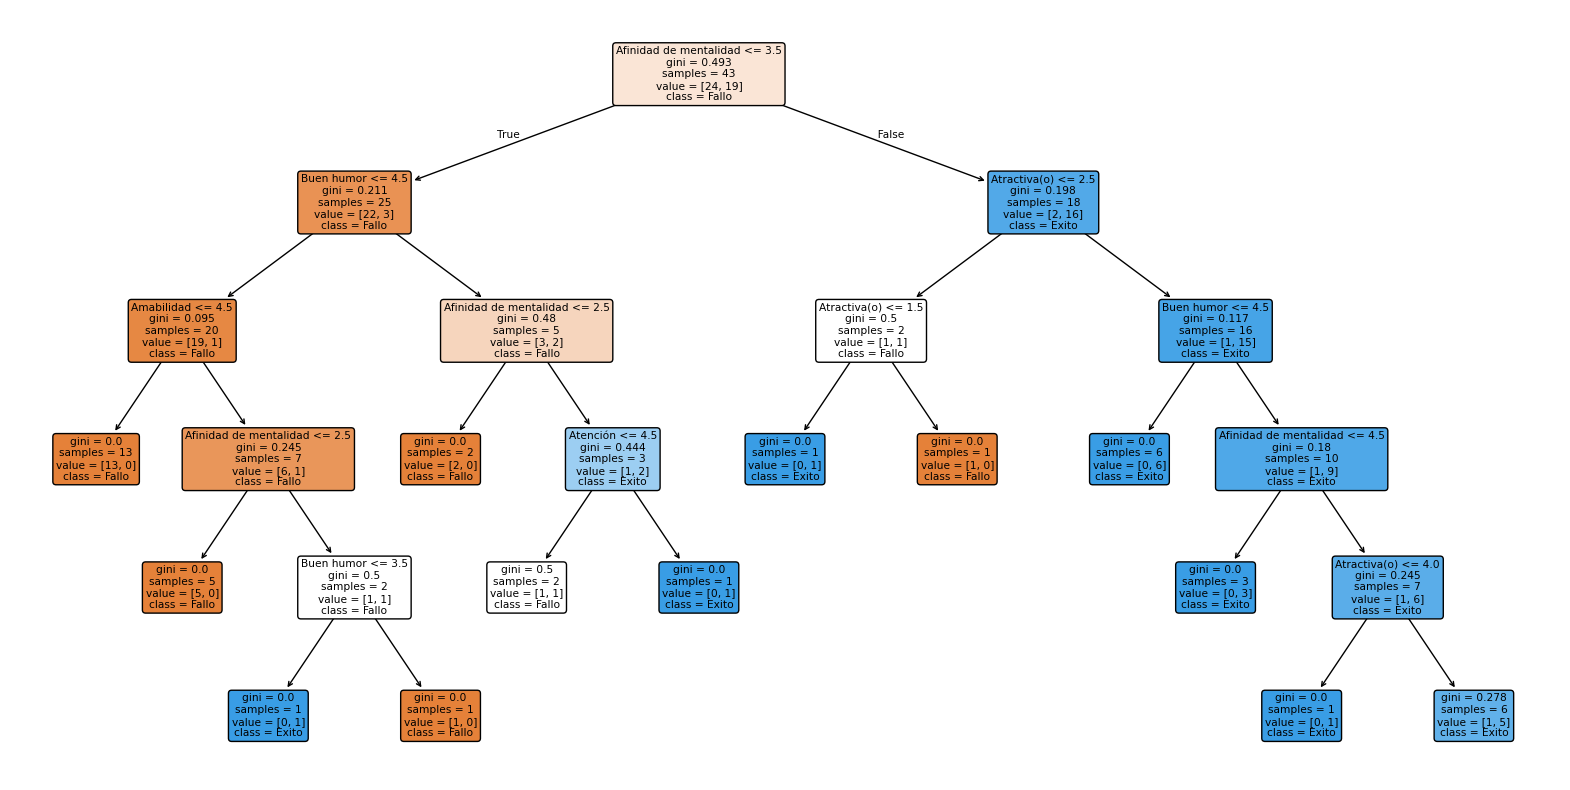

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X.columns, class_names=['Fallo', 'Exito'], filled=True, rounded=True)
plt.show()

## Importancia de las características
La variable `feature_importances_` es un atributo que se utiliza para medir la importancia de las características en un modelo de aprendizaje automático, especialmente en modelos de árboles de decisión y sus variantes, como Random Forest y Gradient Boosting.

**¿Cómo se calcula?**
*Scikit-Learn* mide la importancia de una característica observando cuánto reducen en promedio la impureza los nodos del árbol que utilizan esa característica (a través de todos los árboles en el bosque). Más precisamente, es un promedio ponderado, donde el peso de cada nodo es igual al número de muestras de entrenamiento que se asocian con él.

Text(0, 0.5, 'Importance')

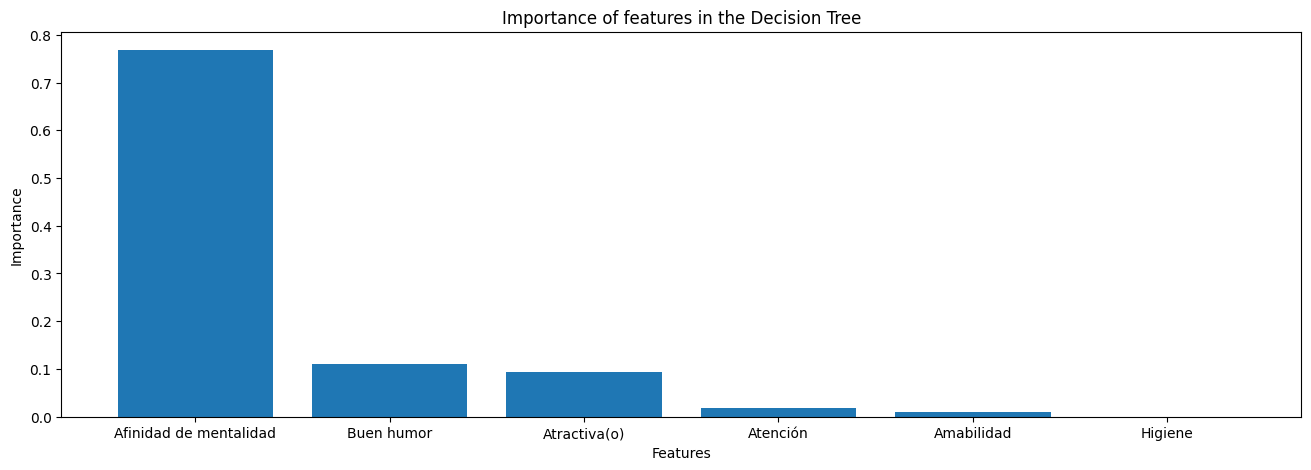

In [ ]:
features = dict(zip(X.columns, clf.feature_importances_))

# Ordenar el diccionario por valores de forma descendente
sorted_dict_desc = dict(sorted(features.items(), key=lambda item: item[1], reverse=True))
#print(sorted_dict_desc, '\n',sorted_dict_desc.keys())

fig = plt.figure(figsize=(16,5))
plt.bar(sorted_dict_desc.keys(), sorted_dict_desc.values())
plt.xlabel('Features')
plt.title('Importance of features in the Decision Tree')
plt.ylabel('Importance')

## Modelo de árbol sin restricción - separamos los datos
Separar los datos en conjuntos de entrenamiento y prueba es una práctica fundamental en el aprendizaje automático (ML) por varias razones:

1. **Evaluación del Modelo**:
   - La separación permite evaluar el rendimiento del modelo en datos que no ha visto durante el entrenamiento. Esto ayuda a medir su capacidad de **generalización**, es decir, cuán bien puede predecir resultados en datos nuevos.

2. **Prevención del Sobreajuste**:
   - Si un modelo se entrena y se evalúa en el mismo conjunto de datos, puede aprender patrones específicos del conjunto de entrenamiento, lo que puede llevar al sobreajuste. Esto significa que el modelo se ajusta demasiado a los datos de entrenamiento y no funciona bien en datos no vistos. La separación ayuda a mitigar este riesgo.

3. **Optimización de Hiperparámetros**:
   - Al tener un conjunto de prueba separado, puedes ajustar los hiperparámetros del modelo utilizando el conjunto de entrenamiento y luego evaluar el rendimiento en el conjunto de prueba. Esto asegura que las decisiones sobre el modelo no se basen en datos que también se usaron para entrenarlo.

4. **Detección de Sesgos**:
   - Separar los datos ayuda a identificar si el modelo tiene sesgos hacia ciertos grupos o características. Al evaluar en un conjunto de prueba, se puede observar si el modelo funciona de manera equitativa en todas las clases o segmentos de datos.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a Decision Tree classifier
clf = DecisionTreeClassifier()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Evaluate the accuracy of the model
print("Training set Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing set Accuracy:", accuracy_score(y_test, y_test_pred))

Training set Accuracy: 0.9411764705882353
Testing set Accuracy: 0.7777777777777778


In [ ]:
# Profundidad del árbol
clf.get_depth()

4

## Modelo de árbol con restricción de profundidad
`max_depth`: Si tu modelo está sobreajustando (alta precisión en los datos de entrenamiento, baja en los de validación/prueba), considera restringir la profundidad.

In [ ]:
clf_md = DecisionTreeClassifier(max_depth=3) # lets limit the tree depth, min_samples_leaf=5

# Train the classifier
clf_md.fit(X_train, y_train)

# Make predictions on both sets
y_train_pred = clf_md.predict(X_train)
y_test_pred = clf_md.predict(X_test)

# Evaluate the accuracy of the model
print("Training set Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing set Accuracy:", accuracy_score(y_test, y_test_pred))
print('Profundidad: ', clf_md.get_depth())

Training set Accuracy: 0.9411764705882353
Testing set Accuracy: 0.7777777777777778
Profundidad:  3


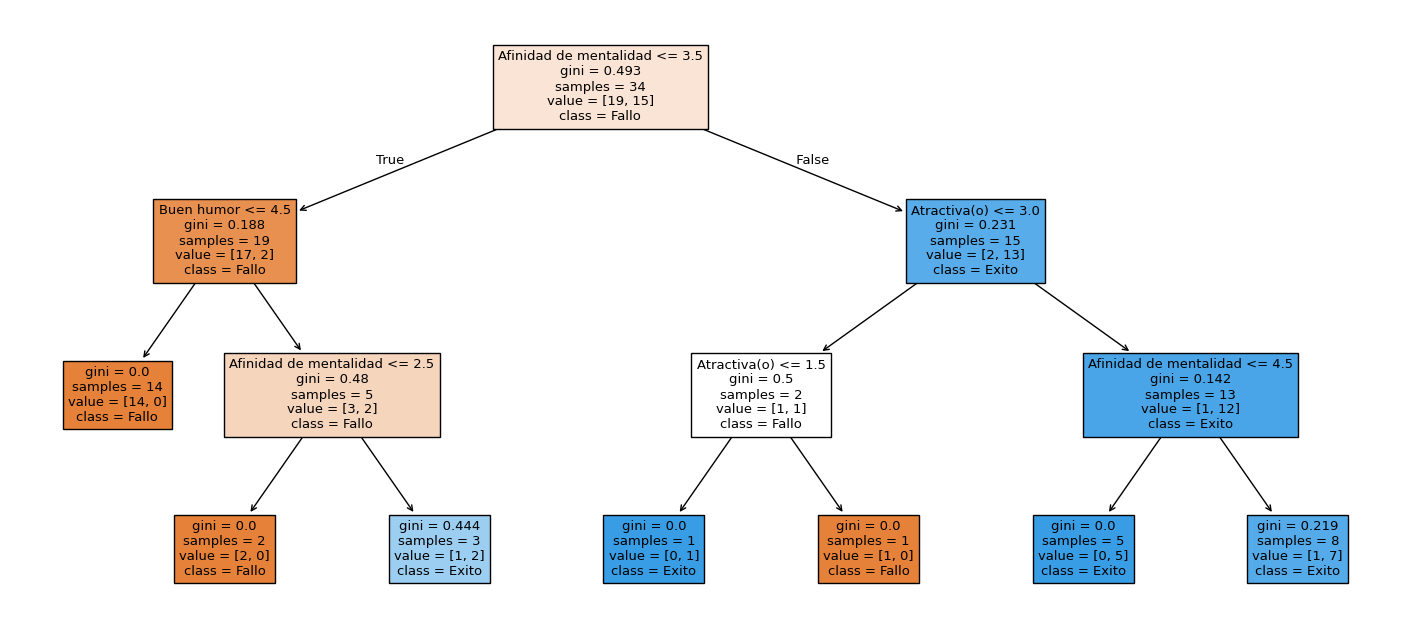

In [ ]:
plt.figure(figsize=(18, 8))
plot_tree(clf_md, feature_names=X.columns, class_names=['Fallo', 'Exito'], filled=True)
plt.show()

## Modelo de árbol con número mínimo de muestras para dividir
`min_samples_split`: Aumenta este valor para evitar que el modelo cree nodos demasiado específicos, lo que puede llevar a sobreajuste. Disminuirlo puede ayudar a capturar patrones más complejos si hay subajuste.

In [ ]:
# Ejemplos
# min_samples_split=12 para requerir al menos 12 muestras para dividir un nodo interno (reduciendo el sobreajuste).
# Establecer min_samples_split=2 (por defecto) para un modelo más complejo si está subajustando.
clf_ms = DecisionTreeClassifier(min_samples_split=12)

# Train the classifier
clf_ms.fit(X_train, y_train)

# Make predictions on both sets
y_train_pred = clf_ms.predict(X_train)
y_test_pred = clf_ms.predict(X_test)

# Evaluate the accuracy of the model
print("Training set Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing set Accuracy:", accuracy_score(y_test, y_test_pred))
print('Profundidad: ', clf_ms.get_depth())

Training set Accuracy: 0.8823529411764706
Testing set Accuracy: 0.7777777777777778
Profundidad:  3


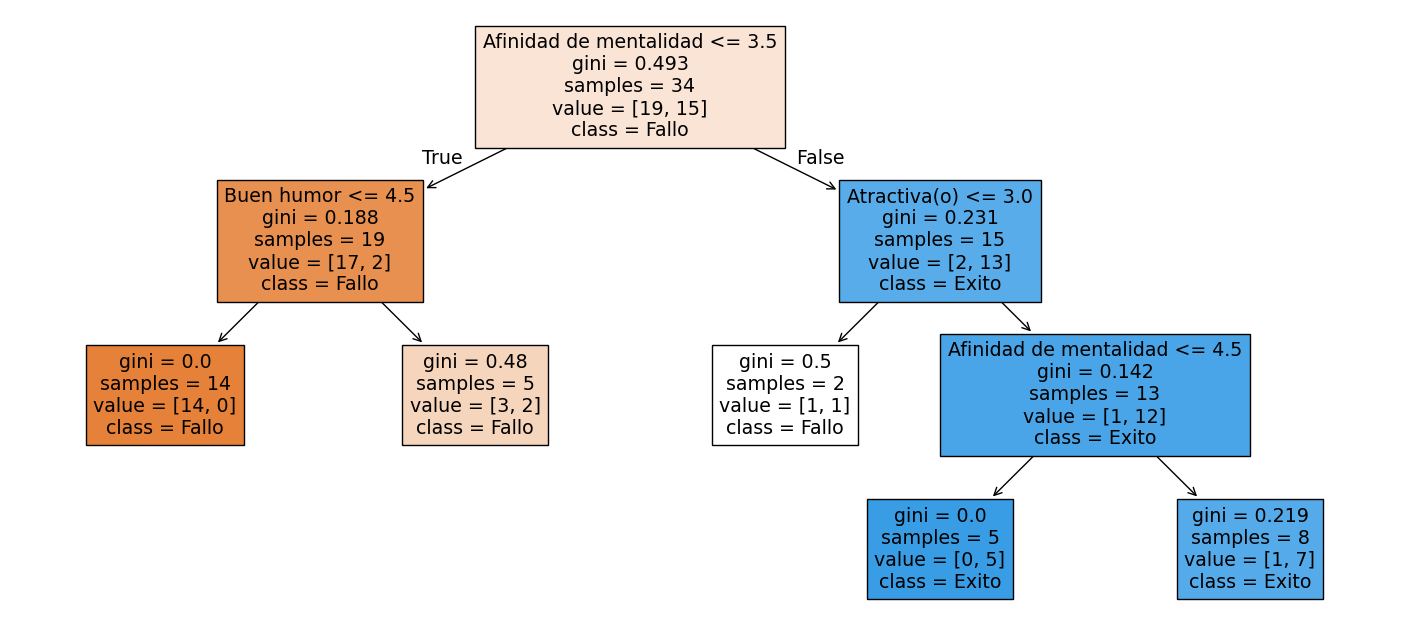

In [ ]:
plt.figure(figsize=(18, 8))
plot_tree(clf_ms, feature_names=X.columns, class_names=['Fallo', 'Exito'], filled=True)
plt.show()

## Árbol con mínimo de muestras por hoja
`min_samples_leaf`: Similar a `min_samples_split`, aumentar este valor ayuda a asegurar que los nodos hoja tengan un número mínimo de muestras, lo que puede reducir el sobreajuste.

In [ ]:
# Ejemplo:
# Establecer min_samples_leaf=5 para asegurar al menos 5 muestras en cada hoja (reduciendo el sobreajuste).
# Establecer min_samples_leaf=1 (por defecto) si el modelo está subajustando.
clf_msl = DecisionTreeClassifier(min_samples_leaf=5)

# Train the classifier
clf_msl.fit(X_train, y_train)

# Make predictions on both sets
y_train_pred = clf_msl.predict(X_train)
y_test_pred = clf_msl.predict(X_test)

# Evaluate the accuracy of the model
print("Training set Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing set Accuracy:", accuracy_score(y_test, y_test_pred))
print('Profundidad: ', clf_msl.get_depth())

Training set Accuracy: 0.8823529411764706
Testing set Accuracy: 0.8888888888888888
Profundidad:  2


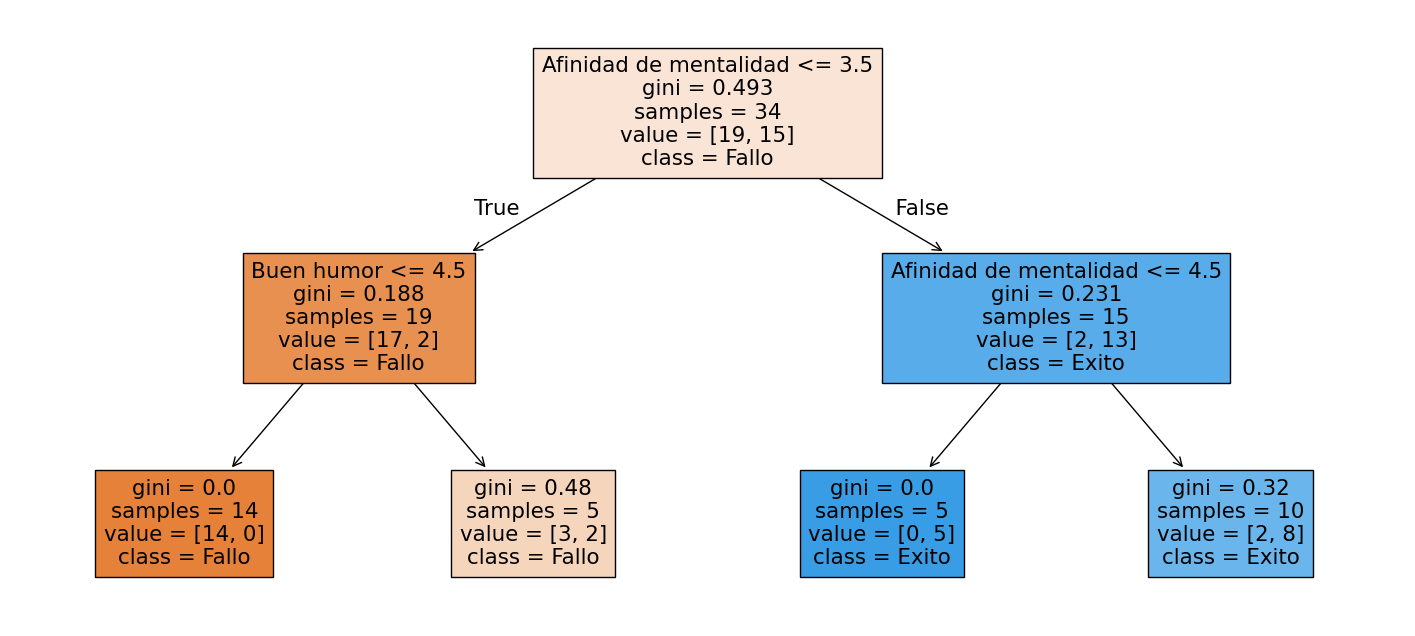

In [ ]:
plt.figure(figsize=(18, 8))
plot_tree(clf_msl, feature_names=X.columns, class_names=['Fallo', 'Exito'], filled=True)
plt.show()